In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

from numba import jit

In [2]:
def N(n):
    return 1*1./np.sqrt(np.sqrt(np.pi)*2**n*factorial(n))

def psix(n, x):
    Hn=hermite(n)
    Px = N(n)*Hn(x)*np.exp(-0.5*x**2)
    return Px

def psixt(n, x, t):
    Hn=hermite(n)
    a = complex(0,1)
    Pxt = N(n)*Hn(x)*np.exp(-0.5*x**2)*np.exp(-a*(n+1/2)*t*np.pi)
    return Pxt

In [3]:
def CrankNicolson(M, O = 0, L = 1, T = 0.5):
    N = 500 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = 3.141111111111111111111111111
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)

    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*w**2*xs**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()
    
    #Obtenção da matriz psi (Ela acumulará para o psi futuro)
    ps = np.zeros((M, N))
    psi_c = np.zeros((M, N))

    #Condição inicial
    ps[:,0] = 1 * psix(0, xs) + 0 * psix(1, xs) #A primeira coluna da matriz terá a equação inicial, em todas as posições
    psi_c = ps.astype(complex)
    #For para o acúmulo de resultados
    for k in range(1,N):
        b = np.matmul(matrizB, np.array(psi_c[0:M, k-1])) #Multiplicação de arrays já que houve uma conversão anterior
        psi_c[0:M, k] = np.linalg.solve(matrizA, b) #Matlab: x = A\b
        #plt.plot(xs, np.absolute(psi_c[0:M, k])**2)
    return psi_c

In [4]:
def multMatrizes(M, us, O = -5, L = 5, T = 10):
    N = 500 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = 3.141111111111111111111111111
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)
    
    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    #V = us #V(x,u(t))
    V = 1/2*m*w**2*xs**2+us

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()

    return np.matmul(np.linalg.inv(matrizA), matrizB)

In [5]:
# Gradiente e função objetivo

def ExactSolution(M, T = 500, L = 5):
    N = 500
    
    psiExato = np.zeros((M, N)).astype(complex)
    r=0
    for i in np.arange(-5, 5, 0.02):
        for j in np.arange(0, 10, 0.02):
            psiExato[r][int(j*50)] = 1/np.sqrt(2)*psixt(0,i,j)+1/np.sqrt(2)*psixt(1,i,j)
        r+=1
    return psiExato

def Objetivo(x, psi, psiExato, tempo):
    A = np.zeros((500,500))
    B = np.zeros((500,500))
    A = multMatrizes(M = 500, us = x[0])
    B = multMatrizes(M = 500, us = x[1])
    return ((np.linalg.norm(np.array(psiExato[0:500, tempo])-np.array(psi)))**2+
            (np.linalg.norm(np.array(psiExato[0:500, tempo+1])-np.array(np.matmul(A,psi))))**2+
            (np.linalg.norm(np.array(psiExato[0:500, tempo+2])-np.array(np.matmul(np.matmul(B,A),psi))))**2)

In [6]:
import random

psi = np.zeros((500,500))
psi_f = np.zeros((500,500))
psi_g = psi_f.astype(complex)
psi = CrankNicolson(M = 500, O = -5, L = 5, T = 10)
psiExato = ExactSolution(M = 500)

In [7]:
def N(n):
    return 1*1./np.sqrt(np.sqrt(np.pi)*2**n*factorial(n))

def psii(n, x):
    Hn=hermite(n)
    Px = N(n)*Hn(x)*np.exp(-0.5*x**2)
    return Px

def psiii(n, x, t):
    Hn=hermite(n)
    a = complex(0,1)
    Pxt = N(n)*Hn(x.real)*np.exp(-0.5*x**2)*np.exp(-a*(n+1/2)*t*np.pi)
    return Pxt

In [8]:
u1 = []
u2 = []
vetor = []
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
tempo = 0
xs = np.linspace(-5,5,500)

psi = CrankNicolson(M = 500, O = -5, L = 5, T = 10)
psiExato = ExactSolution(M = 500)
tempo = 0;

while tempo < 498:
    psi_g[0:500, tempo] = psi[0:500, tempo]
    res = optimize.minimize(Objetivo, u1, args=(psi_g, psiExato, tempo), method='SLSQP')
    print("iteracao: ", tempo+1)
    print(res)
    print("-----------------")
    print("-----------------")
    D = multMatrizes(M = 500, us = res.x[0])
    psi = np.matmul(D, psi)
    tempo += 1
    u1 = []
    u1.append(res.x[1])
    u1.append(random.uniform(-5, 5))

iteracao:  1
     fun: 75149.7067614844
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([4.73678815, 2.4329714 ])
-----------------
-----------------
iteracao:  2
     fun: 75299.41413197719
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([2.4329714 , 4.16432207])
-----------------
-----------------
iteracao:  3
     fun: 75449.12210112436
     jac: array([-0.00097656,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([4.16432207, 1.49538499])
-----------------
-----------------
iteracao:  4
     fun: 75598.83057163442
     jac: array([-0.00097656,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array

iteracao:  32
     fun: 79789.77415062953
     jac: array([0.00195312, 0.        ])
 message: 'Optimization terminated successfully'
    nfev: 4
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([-16.68789203,   3.00420029])
-----------------
-----------------
iteracao:  33
     fun: 79939.43045321674
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([3.00420029, 0.08059896])
-----------------
-----------------
iteracao:  34
     fun: 80089.09581221154
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([ 0.08059896, -1.56298062])
-----------------
-----------------
iteracao:  35
     fun: 80238.6745137968
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 30
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([84.83

iteracao:  63
     fun: 84420.24435447906
     jac: array([0.00097656, 0.00097656])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([12.09401016,  3.9552456 ])
-----------------
-----------------
iteracao:  64
     fun: 84569.98146181965
     jac: array([0.00097656, 0.        ])
 message: 'Optimization terminated successfully'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([3.9552456 , 4.53050975])
-----------------
-----------------
iteracao:  65
     fun: 84719.62660579698
     jac: array([0.00195312, 0.        ])
 message: 'Optimization terminated successfully'
    nfev: 38
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([-5.77639012, -3.60491365])
-----------------
-----------------
iteracao:  66
     fun: 84869.03983018165
     jac: array([ 0.        , -0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 37
     nit: 8
    njev: 8


iteracao:  93
     fun: 88885.72324030135
     jac: array([0.00097656, 0.00097656])
 message: 'Optimization terminated successfully'
    nfev: 68
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([-69.1924859 ,  12.40175701])
-----------------
-----------------
iteracao:  94
     fun: 89027.72614639858
     jac: array([ 0.00195312, -0.00878906])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([-31.6873959 , -18.77615932])
-----------------
-----------------
iteracao:  95
     fun: 89169.11595760338
     jac: array([-0.00488281, -0.00488281])
 message: 'Optimization terminated successfully'
    nfev: 66
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([-27.1167196 ,   5.68705901])
-----------------
-----------------
iteracao:  96
     fun: 89310.55293376988
     jac: array([-0.00488281, -0.00585938])
 message: 'Optimization terminated successfully'
    nfev: 63
     ni

iteracao:  123
     fun: 93393.38657873034
     jac: array([ 0.        , -0.00097656])
 message: 'Optimization terminated successfully'
    nfev: 106
     nit: 28
    njev: 28
  status: 0
 success: True
       x: array([1470.42653117,    2.1650878 ])
-----------------
-----------------
iteracao:  124
     fun: 93560.9544798756
     jac: array([ 0.00097656, -0.0078125 ])
 message: 'Optimization terminated successfully'
    nfev: 61
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([-408.59170362, -232.65948872])
-----------------
-----------------
iteracao:  125
     fun: 93683.84811180882
     jac: array([-0.00292969,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 119
     nit: 32
    njev: 32
  status: 0
 success: True
       x: array([298.95451625,   8.56962288])
-----------------
-----------------
iteracao:  126
     fun: 93807.5319408802
     jac: array([-0.0078125 ,  0.00585938])
 message: 'Optimization terminated successfully'
    nfev

iteracao:  153
     fun: 96146.21258593371
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 30
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([-11.18867932,   7.43603241])
-----------------
-----------------
iteracao:  154
     fun: 96145.20510236695
     jac: array([0.00097656, 0.        ])
 message: 'Optimization terminated successfully'
    nfev: 49
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([-4.88142422,  7.4506381 ])
-----------------
-----------------
iteracao:  155
     fun: 96142.19368746037
     jac: array([-0.00292969, -0.00097656])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([1.82988616, 7.42436313])
-----------------
-----------------
iteracao:  156
     fun: 96141.23378032165
     jac: array([-0.00292969, -0.00292969])
 message: 'Optimization terminated successfully'
    nfev: 50
     nit: 12
    njev: 12

iteracao:  183
     fun: 101745.46415412903
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([442.35249553,  10.85023325])
-----------------
-----------------
iteracao:  184
     fun: 101874.47046738869
     jac: array([-0.00292969, -0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 65
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([407.81759115,  11.75294185])
-----------------
-----------------
iteracao:  185
     fun: 102192.48182201319
     jac: array([-0.00195312,  0.00097656])
 message: 'Optimization terminated successfully'
    nfev: 79
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([475.61338492,  12.42425261])
-----------------
-----------------
iteracao:  186
     fun: 102362.40529929954
     jac: array([-0.00390625, -0.00097656])
 message: 'Optimization terminated successfully'
    nfev: 70
     nit: 19


iteracao:  212
     fun: 105974.78307251632
     jac: array([0.00195312, 0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 53
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([-253.25917451,    8.8655029 ])
-----------------
-----------------
iteracao:  213
     fun: 105972.40188068837
     jac: array([ 0.00195312, -0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 48
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([-196.42152694,    9.67316342])
-----------------
-----------------
iteracao:  214
     fun: 106107.08909514998
     jac: array([ 0.        , -0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 55
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([-147.07086919,   10.59733931])
-----------------
-----------------
iteracao:  215
     fun: 106369.76251096594
     jac: array([ 0.        , -0.00195312])
 message: 'Optimization terminated successfully'
    

iteracao:  242
     fun: 109726.63746140563
     jac: array([-0.00195312,  0.00097656])
 message: 'Optimization terminated successfully'
    nfev: 53
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([269.79388278,   6.78197162])
-----------------
-----------------
iteracao:  243
     fun: 110115.45138455235
     jac: array([-0.00390625, -0.00097656])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([270.63084394,   7.84359994])
-----------------
-----------------
iteracao:  244
     fun: 110504.81058506397
     jac: array([ 0.00292969, -0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 68
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([359.6591763 ,   8.31478537])
-----------------
-----------------
iteracao:  245
     fun: 110492.00762695109
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 12


iteracao:  271
     fun: 114869.7274233563
     jac: array([0.00390625, 0.00292969])
 message: 'Optimization terminated successfully'
    nfev: 77
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([-622.8081835 ,    9.46652558])
-----------------
-----------------
iteracao:  272
     fun: 115120.61384487359
     jac: array([ 0.00390625, -0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 77
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([-688.1599331 ,    8.89803684])
-----------------
-----------------
iteracao:  273
     fun: 115091.5435939754
     jac: array([0.00585938, 0.00585938])
 message: 'Optimization terminated successfully'
    nfev: 59
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([-592.50148019,    8.62843201])
-----------------
-----------------
iteracao:  274
     fun: 115217.74502007732
     jac: array([0.00390625, 0.00097656])
 message: 'Optimization terminated successfully'
    nfev: 

iteracao:  300
     fun: 118748.99563386152
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 41
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([233.78306173,   8.78262774])
-----------------
-----------------
iteracao:  301
     fun: 118553.95925416546
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([224.13914769,   8.45185993])
-----------------
-----------------
iteracao:  302
     fun: 118626.5643126024
     jac: array([0.00097656, 0.        ])
 message: 'Optimization terminated successfully'
    nfev: 46
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([191.41560039,   8.85874245])
-----------------
-----------------
iteracao:  303
     fun: 119058.65430074962
     jac: array([0.00488281, 0.00292969])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 15
    njev: 15
  status: 

iteracao:  329
     fun: 123715.11791117208
     jac: array([ 0.00097656, -0.00878906])
 message: 'Optimization terminated successfully'
    nfev: 88
     nit: 24
    njev: 24
  status: 0
 success: True
       x: array([-1836.04938313,     8.35365893])
-----------------
-----------------
iteracao:  330
     fun: 123785.54624623066
     jac: array([ 0.       , -0.0078125])
 message: 'Optimization terminated successfully'
    nfev: 78
     nit: 22
    njev: 22
  status: 0
 success: True
       x: array([-1281.93419789,     7.75770918])
-----------------
-----------------
iteracao:  331
     fun: 123977.98961612364
     jac: array([-0.00390625,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 87
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([-1088.44915394,     7.523996  ])
-----------------
-----------------
iteracao:  332
     fun: 124069.2818993818
     jac: array([0.00390625, 0.        ])
 message: 'Optimization terminated successfully'
 

iteracao:  358
     fun: 127216.54457080692
     jac: array([ 0.        , -0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 51
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([-66.21476964,   9.2744746 ])
-----------------
-----------------
iteracao:  359
     fun: 127352.56578656129
     jac: array([-0.00195312, -0.00390625])
 message: 'Optimization terminated successfully'
    nfev: 43
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([-44.20819698,   9.63724843])
-----------------
-----------------
iteracao:  360
     fun: 127510.55302690476
     jac: array([0.00390625, 0.        ])
 message: 'Optimization terminated successfully'
    nfev: 49
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([-22.09393503,   9.93992004])
-----------------
-----------------
iteracao:  361
     fun: 127681.51339201127
     jac: array([-0.00292969, -0.00292969])
 message: 'Optimization terminated successfully'
    nfev: 

iteracao:  387
     fun: 132423.28403247733
     jac: array([0.00195312, 0.        ])
 message: 'Optimization terminated successfully'
    nfev: 98
     nit: 25
    njev: 25
  status: 0
 success: True
       x: array([3405.76391659,    9.64802793])
-----------------
-----------------
iteracao:  388
     fun: 132590.65671425642
     jac: array([ 0.00195312, -0.00390625])
 message: 'Optimization terminated successfully'
    nfev: 80
     nit: 22
    njev: 22
  status: 0
 success: True
       x: array([3684.81428991,   23.89192637])
-----------------
-----------------
iteracao:  389
     fun: 132733.92071129705
     jac: array([0.       , 0.0234375])
 message: 'Optimization terminated successfully'
    nfev: 102
     nit: 29
    njev: 29
  status: 0
 success: True
       x: array([4417.11225902,   37.21524535])
-----------------
-----------------
iteracao:  390
     fun: 132889.647949268
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 140
     nit: 37


iteracao:  416
     fun: 135452.42138095788
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 42
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([-114.98066688,    8.18770994])
-----------------
-----------------
iteracao:  417
     fun: 135549.52491327567
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 39
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([-100.22610516,    8.17349806])
-----------------
-----------------
iteracao:  418
     fun: 135652.55047495879
     jac: array([0.01171875, 0.00585938])
 message: 'Optimization terminated successfully'
    nfev: 61
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([-85.79629554,   8.31853488])
-----------------
-----------------
iteracao:  419
     fun: 135762.80972765782
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 46
     nit: 15
    njev: 15
  status: 0
 success:

iteracao:  446
     fun: 140687.13725239784
     jac: array([0.        , 0.00585938])
 message: 'Optimization terminated successfully'
    nfev: 76
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([416.28122403,   9.07730424])
-----------------
-----------------
iteracao:  447
     fun: 140901.28321082698
     jac: array([0.00585938, 0.0078125 ])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([456.80472606,   9.70447633])
-----------------
-----------------
iteracao:  448
     fun: 141113.7710094508
     jac: array([0.00390625, 0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 78
     nit: 19
    njev: 19
  status: 0
 success: True
       x: array([506.40898689,   8.87957453])
-----------------
-----------------
iteracao:  449
     fun: 141324.3226611143
     jac: array([0.00976562, 0.0078125 ])
 message: 'Optimization terminated successfully'
    nfev: 71
     

iteracao:  475
     fun: 145264.76974085823
     jac: array([-0.00195312, -0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 50
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([-294.23629939,   12.81642208])
-----------------
-----------------
iteracao:  476
     fun: 145365.2029264369
     jac: array([-0.0078125 , -0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 61
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([-262.99755987,   12.76388171])
-----------------
-----------------
iteracao:  477
     fun: 145464.80332031604
     jac: array([0.00195312, 0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 66
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([-234.70523728,   13.03681307])
-----------------
-----------------
iteracao:  478
     fun: 145564.03953896827
     jac: array([-0.00390625,  0.00195312])
 message: 'Optimization terminated successfully'
    n

IndexError: index 500 is out of bounds for axis 1 with size 500

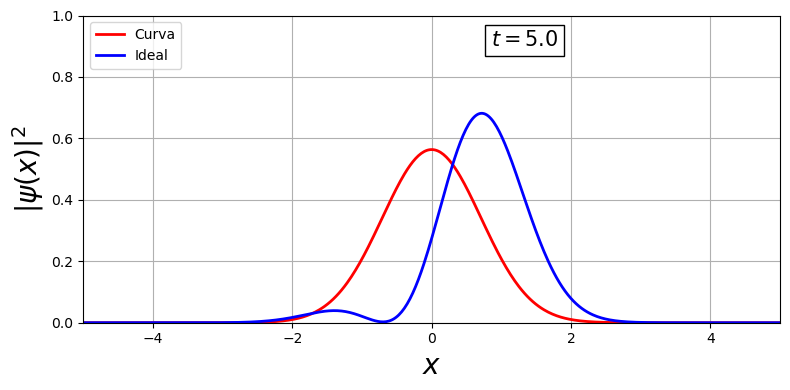

In [9]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

def animate(i):
    xs = np.linspace(-5,5,500)
    ln1.set_data(xs, np.absolute(psi_g[0:500,i-1])**2)
    ln2.set_data(xs, np.absolute(psiExato[0:500,i-1])**2)
    time_text.set_text('$t=$'+'{:.1f}'.format(i/100))
    
fig, ax = plt.subplots(1, 1,figsize=(8,4))
ax.grid()
ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Curva')
ln2, = plt.plot([], [], 'b-', lw=2, markersize=8, label='Ideal')
time_text = ax.text(0.85, 0.9, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(0, 1)
ax.set_xlim(-5,5)
title = ax.set_title('Resposta analítica')
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.legend(loc='upper left')
ax.set_title('')
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=500, interval=200)
ani.save('500x500_version1.gif',writer='pillow',fps=15,dpi=100)

In [10]:
def CrankNicolson(M, O = 0, L = 1, T = 0.5):
    N = 500 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = 3.141111111111111111111111111
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)

    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*w**2*xs**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()
    
    #Obtenção da matriz psi (Ela acumulará para o psi futuro)
    ps = np.zeros((M, N))
    psi_c = np.zeros((M, N))

    #Condição inicial
    ps[:,0] = 0.80 * psix(0, xs) + 0.60 * psix(1, xs) #A primeira coluna da matriz terá a equação inicial, em todas as posições
    psi_c = ps.astype(complex)
    #For para o acúmulo de resultados
    for k in range(1,N):
        b = np.matmul(matrizB, np.array(psi_c[0:M, k-1])) #Multiplicação de arrays já que houve uma conversão anterior
        psi_c[0:M, k] = np.linalg.solve(matrizA, b) #Matlab: x = A\b
        #plt.plot(xs, np.absolute(psi_c[0:M, k])**2)
    return psi_c

In [11]:
import random

psi = np.zeros((500,500))
psi_f = np.zeros((500,500))
psi_g = psi_f.astype(complex)
psi = CrankNicolson(M = 500, O = -5, L = 5, T = 10)
psiExato = ExactSolution(M = 500)

In [12]:
u1 = []
u2 = []
vetor = []
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
tempo = 0
xs = np.linspace(-5,5,500)

psi = CrankNicolson(M = 500, O = -5, L = 5, T = 10)
psiExato = ExactSolution(M = 500)
tempo = 0;

while tempo < 498:
    psi_g[0:500, tempo] = psi[0:500, tempo]
    res = optimize.minimize(Objetivo, u1, args=(psi_g, psiExato, tempo), method='SLSQP')
    print("iteracao: ", tempo+1)
    print(res)
    print("-----------------")
    print("-----------------")
    D = multMatrizes(M = 500, us = res.x[0])
    psi = np.matmul(D, psi)
    tempo += 1
    u1 = []
    u1.append(res.x[1])
    u1.append(random.uniform(-5, 5))

iteracao:  1
     fun: 75149.70540248371
     jac: array([-0.00097656,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([1.3355026 , 2.71209227])
-----------------
-----------------
iteracao:  2
     fun: 75299.4112956086
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([2.71209227, 3.80974432])
-----------------
-----------------
iteracao:  3
     fun: 75449.11758829876
     jac: array([0.        , 0.00097656])
 message: 'Optimization terminated successfully'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([ 3.80974432, -3.64418481])
-----------------
-----------------
iteracao:  4
     fun: 75598.82417972357
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array

iteracao:  32
     fun: 79790.5781176184
     jac: array([-0.00097656,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([ 3.22935036, -3.73222365])
-----------------
-----------------
iteracao:  33
     fun: 79940.3854851861
     jac: array([-0.00097656,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([-3.73222365, -0.72859016])
-----------------
-----------------
iteracao:  34
     fun: 80090.2000780832
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([-0.72859016,  1.16128239])
-----------------
-----------------
iteracao:  35
     fun: 80239.25472492671
     jac: array([0.        , 0.00097656])
 message: 'Optimization terminated successfully'
    nfev: 41
     nit: 10
    njev: 10
  status: 0
 su

iteracao:  63
     fun: 84425.43190352438
     jac: array([0.00097656, 0.        ])
 message: 'Optimization terminated successfully'
    nfev: 41
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([-34.82420571,  -4.65791436])
-----------------
-----------------
iteracao:  64
     fun: 84573.82905088262
     jac: array([-0.00097656, -0.00097656])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([-15.64527065,  -4.53910931])
-----------------
-----------------
iteracao:  65
     fun: 84722.1768100506
     jac: array([0.00097656, 0.        ])
 message: 'Optimization terminated successfully'
    nfev: 20
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([-4.53544721, -2.85253991])
-----------------
-----------------
iteracao:  66
     fun: 84870.45332410865
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 24
     nit: 8
    njev: 8
  status: 

iteracao:  93
     fun: 88864.4740715239
     jac: array([-0.00488281,  0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([39.25592801, 18.20045483])
-----------------
-----------------
iteracao:  94
     fun: 89014.06794325286
     jac: array([-0.00097656,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 32
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([43.14117316, 13.69664468])
-----------------
-----------------
iteracao:  95
     fun: 89165.00645905008
     jac: array([-0.00195312, -0.00097656])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([43.06248285, 13.15987233])
-----------------
-----------------
iteracao:  96
     fun: 89317.34319393156
     jac: array([0.        , 0.00097656])
 message: 'Optimization terminated successfully'
    nfev: 32
     nit: 7
    nj

iteracao:  123
     fun: 93148.47632308603
     jac: array([0.00097656, 0.        ])
 message: 'Optimization terminated successfully'
    nfev: 69
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([42.59009631,  9.47587475])
-----------------
-----------------
iteracao:  124
     fun: 93284.83576166253
     jac: array([0.00292969, 0.00292969])
 message: 'Optimization terminated successfully'
    nfev: 69
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([37.2249002 , 10.20609085])
-----------------
-----------------
iteracao:  125
     fun: 93426.74757241545
     jac: array([-0.00097656,  0.00585938])
 message: 'Optimization terminated successfully'
    nfev: 29
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([29.7260042 , 11.39263029])
-----------------
-----------------
iteracao:  126
     fun: 93573.16909832145
     jac: array([ 0.00195312, -0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 25
     nit: 5

iteracao:  153
     fun: 97358.12201529075
     jac: array([-0.00195312,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 47
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([57.7144865,  7.7222293])
-----------------
-----------------
iteracao:  154
     fun: 97635.5789822714
     jac: array([-0.00195312,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([96.98693497,  8.16001895])
-----------------
-----------------
iteracao:  155
     fun: 97836.50114255994
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 48
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([172.80970883,   8.48478926])
-----------------
-----------------
iteracao:  156
     fun: 97902.87219174021
     jac: array([0.        , 0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 62
     nit: 17
    njev: 17


iteracao:  183
     fun: 101269.66798750515
     jac: array([0.00292969, 0.00097656])
 message: 'Optimization terminated successfully'
    nfev: 59
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([28.79260296,  9.63401699])
-----------------
-----------------
iteracao:  184
     fun: 101321.82113038911
     jac: array([-0.00195312, -0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 43
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([35.67692896, 10.07694687])
-----------------
-----------------
iteracao:  185
     fun: 101400.25192280114
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 48
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([39.67589413, 10.54135838])
-----------------
-----------------
iteracao:  186
     fun: 101510.73536127963
     jac: array([0.00195312, 0.00097656])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 11
    njev: 

iteracao:  213
     fun: 106581.23724688098
     jac: array([0.00097656, 0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 87
     nit: 24
    njev: 24
  status: 0
 success: True
       x: array([-2259.51512578,    15.14682345])
-----------------
-----------------
iteracao:  214
     fun: 106721.31327650309
     jac: array([-0.00097656,  0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 79
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([-1067.96098468,    11.6264297 ])
-----------------
-----------------
iteracao:  215
     fun: 106881.52042412467
     jac: array([-0.00097656,  0.00097656])
 message: 'Optimization terminated successfully'
    nfev: 66
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([-1255.89159344,     7.89810226])
-----------------
-----------------
iteracao:  216
     fun: 106937.27073495669
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 59
   

iteracao:  243
     fun: 109327.85762788559
     jac: array([0.00390625, 0.00097656])
 message: 'Optimization terminated successfully'
    nfev: 50
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([80.96353542,  4.1381488 ])
-----------------
-----------------
iteracao:  244
     fun: 109319.56013118818
     jac: array([ 0.        , -0.00097656])
 message: 'Optimization terminated successfully'
    nfev: 48
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([71.06084185,  4.26369935])
-----------------
-----------------
iteracao:  245
     fun: 109423.70946150544
     jac: array([0.00195312, 0.        ])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([60.84752044,  4.43350508])
-----------------
-----------------
iteracao:  246
     fun: 109629.2653551511
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 27
     nit: 9
    njev: 9


iteracao:  273
     fun: 115420.78862592325
     jac: array([0.00097656, 0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 70
     nit: 19
    njev: 19
  status: 0
 success: True
       x: array([886.89738731,   9.66539691])
-----------------
-----------------
iteracao:  274
     fun: 115534.36288694381
     jac: array([ 0.00097656, -0.00488281])
 message: 'Optimization terminated successfully'
    nfev: 73
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([1242.9696472 ,   11.53202014])
-----------------
-----------------
iteracao:  275
     fun: 115727.97075333711
     jac: array([0.00195312, 0.00097656])
 message: 'Optimization terminated successfully'
    nfev: 80
     nit: 22
    njev: 22
  status: 0
 success: True
       x: array([1073.76764716,    8.03899371])
-----------------
-----------------
iteracao:  276
     fun: 115923.09098166607
     jac: array([ 0.00195312, -0.00195312])
 message: 'Optimization terminated successfully'
    nfev

iteracao:  302
     fun: 117580.76374981555
     jac: array([ 0.00097656, -0.00292969])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([41.57494773,  6.53147715])
-----------------
-----------------
iteracao:  303
     fun: 117537.10243559928
     jac: array([0.00488281, 0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 61
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([35.53109927,  6.73965136])
-----------------
-----------------
iteracao:  304
     fun: 117556.83968545015
     jac: array([-0.00292969, -0.00390625])
 message: 'Optimization terminated successfully'
    nfev: 42
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([29.59357623,  6.81997401])
-----------------
-----------------
iteracao:  305
     fun: 117630.74011652662
     jac: array([-0.00976562, -0.00585938])
 message: 'Optimization terminated successfully'
    nfev: 45
   

iteracao:  332
     fun: 122691.16159624213
     jac: array([0.00195312, 0.        ])
 message: 'Optimization terminated successfully'
    nfev: 49
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([85.47873628, 12.6407942 ])
-----------------
-----------------
iteracao:  333
     fun: 123044.7552544811
     jac: array([-0.00097656,  0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 57
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([111.84890619,  13.2847333 ])
-----------------
-----------------
iteracao:  334
     fun: 123326.11254411095
     jac: array([0.00292969, 0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 63
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([145.36462905,  13.75135512])
-----------------
-----------------
iteracao:  335
     fun: 123512.82418885062
     jac: array([-0.00195312,  0.00097656])
 message: 'Optimization terminated successfully'
    nfev: 56
  

iteracao:  361
     fun: 127858.65236747076
     jac: array([ 0.00195312, -0.00292969])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([-580.85953476,    9.91059455])
-----------------
-----------------
iteracao:  362
     fun: 127925.15678764021
     jac: array([-0.00292969, -0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 53
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([-532.26156044,    9.58327045])
-----------------
-----------------
iteracao:  363
     fun: 127943.42162534769
     jac: array([-0.00585938, -0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 63
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([-476.86439604,    9.55892718])
-----------------
-----------------
iteracao:  364
     fun: 127994.46199856867
     jac: array([-0.00195312,  0.        ])
 message: 'Optimization terminated successfully'
  

iteracao:  390
     fun: 129619.74424362302
     jac: array([-0.00292969, -0.00097656])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([23.88062537,  7.00412443])
-----------------
-----------------
iteracao:  391
     fun: 129777.14854162751
     jac: array([-0.00292969, -0.00292969])
 message: 'Optimization terminated successfully'
    nfev: 46
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([35.01007233,  7.02899645])
-----------------
-----------------
iteracao:  392
     fun: 129949.30968081647
     jac: array([0.00195312, 0.00292969])
 message: 'Optimization terminated successfully'
    nfev: 43
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([46.41111084,  7.00550855])
-----------------
-----------------
iteracao:  393
     fun: 130136.37221346684
     jac: array([ 0.        , -0.00292969])
 message: 'Optimization terminated successfully'
    nfev: 42
   

iteracao:  420
     fun: 136784.17979977722
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 85
     nit: 24
    njev: 24
  status: 0
 success: True
       x: array([990.74729927,  10.21249416])
-----------------
-----------------
iteracao:  421
     fun: 137010.04409387332
     jac: array([0.        , 0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 81
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([1188.05032308,    9.2164821 ])
-----------------
-----------------
iteracao:  422
     fun: 137226.26430032105
     jac: array([0.00390625, 0.00585938])
 message: 'Optimization terminated successfully'
    nfev: 97
     nit: 23
    njev: 23
  status: 0
 success: True
       x: array([1447.15407156,    9.36781058])
-----------------
-----------------
iteracao:  423
     fun: 137437.92002203217
     jac: array([ 0.00390625, -0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 96
     nit: 23


iteracao:  449
     fun: 140604.70203764157
     jac: array([0.00195312, 0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 53
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([-66.58953832,  14.85381932])
-----------------
-----------------
iteracao:  450
     fun: 140684.54204649254
     jac: array([-0.00585938, -0.00585938])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([-46.16383086,  14.29960328])
-----------------
-----------------
iteracao:  451
     fun: 140767.4862376958
     jac: array([0.00195312, 0.        ])
 message: 'Optimization terminated successfully'
    nfev: 50
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([-26.76084289,  14.1518099 ])
-----------------
-----------------
iteracao:  452
     fun: 140854.2907336832
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 31
     nit: 10
    nj

iteracao:  479
     fun: 145232.33658972962
     jac: array([-0.00390625,  0.00585938])
 message: 'Optimization terminated successfully'
    nfev: 67
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([889.90692424,   7.29016065])
-----------------
-----------------
iteracao:  480
     fun: 145425.5149618179
     jac: array([-0.00390625, -0.00585938])
 message: 'Optimization terminated successfully'
    nfev: 86
     nit: 23
    njev: 23
  status: 0
 success: True
       x: array([1017.71423432,    7.06812808])
-----------------
-----------------
iteracao:  481
     fun: 145615.3584241942
     jac: array([-0.00195312, -0.00195312])
 message: 'Optimization terminated successfully'
    nfev: 78
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([1178.68698535,    7.15957706])
-----------------
-----------------
iteracao:  482
     fun: 145801.37889468583
     jac: array([ 0.        , -0.00390625])
 message: 'Optimization terminated successfully'
    nf

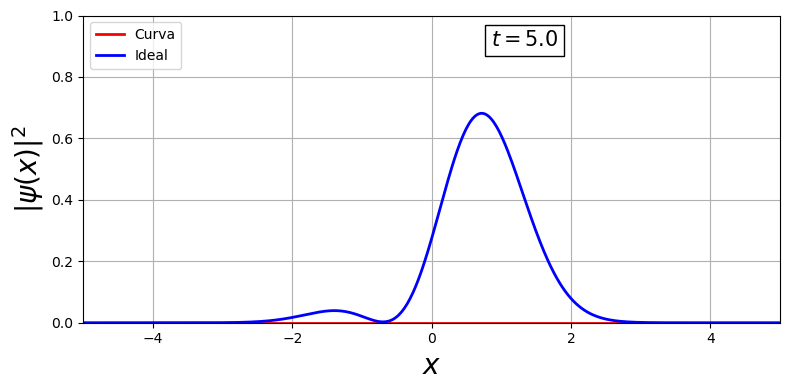

In [13]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

def animate(i):
    xs = np.linspace(-5,5,500)
    ln1.set_data(xs, np.absolute(psi_g[0:500,i-1])**2)
    ln2.set_data(xs, np.absolute(psiExato[0:500,i-1])**2)
    time_text.set_text('$t=$'+'{:.1f}'.format(i/100))
    
fig, ax = plt.subplots(1, 1,figsize=(8,4))
ax.grid()
ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Curva')
ln2, = plt.plot([], [], 'b-', lw=2, markersize=8, label='Ideal')
time_text = ax.text(0.85, 0.9, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(0, 1)
ax.set_xlim(-5,5)
title = ax.set_title('Resposta analítica')
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.legend(loc='upper left')
ax.set_title('')
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=500, interval=200)
ani.save('500x500_version2.gif',writer='pillow',fps=15,dpi=100)